In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [25]:
# taking only 1M datapoints to reduce computational power and time required
df = pd.read_csv('final_features.csv')
data = df.sample(n = 100001)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [26]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
325927,0.000000,0.000000,0.333322,0.090908,0.124998,0.041666,0.0,0.0,16.0,16.0,...,9.916620,-20.474477,-69.100220,33.984330,11.218117,15.257108,-67.197423,89.362409,6.604263,111.012312
29958,0.666644,0.666644,0.249994,0.249994,0.428565,0.428565,1.0,1.0,0.0,7.0,...,21.565672,-21.559930,-19.066460,33.118830,-32.545566,0.997359,-43.985768,85.991640,-21.132015,13.968308
295007,0.249994,0.166664,0.571420,0.363633,0.384612,0.263157,0.0,1.0,6.0,16.0,...,-2.130194,16.000496,-25.962658,-36.629608,-69.717198,-84.894676,11.464158,-37.989339,3.848511,26.574310
358941,0.599988,0.499992,0.749981,0.749981,0.666659,0.599994,1.0,1.0,1.0,9.5,...,4.691129,0.013804,-0.360108,59.210307,-18.850000,-92.205518,-25.998786,54.830563,8.521821,30.225916
168428,0.374995,0.374995,0.333328,0.285710,0.333331,0.333331,0.0,1.0,0.0,15.0,...,-14.703725,40.991142,-110.872596,30.195823,-73.887874,72.073380,33.550072,106.739274,99.763524,172.660605


### Random train test split

In [27]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [28]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 217)
Number of data points in test data : (30001, 217)


In [29]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6284142857142857 Class 1:  0.3715857142857143
---------- Distribution of output variable in train data ----------
Class 0:  0.37158761374620847 Class 1:  0.37158761374620847


In [30]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## Dummy model

Log loss on Test Data using Random Model 0.878103108168104


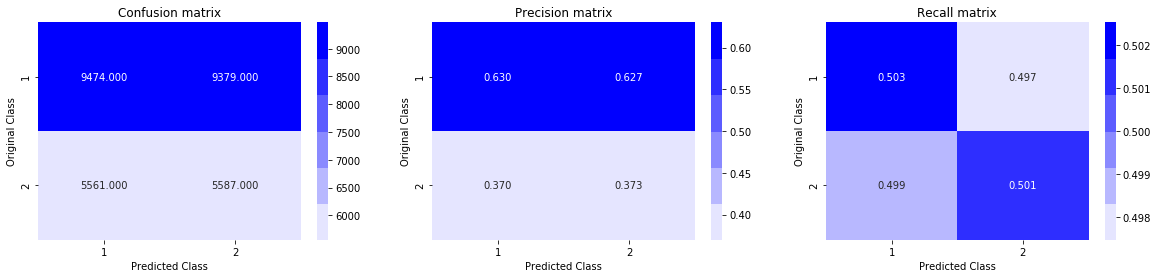

In [31]:
# Credit: https://stackoverflow.com/a/18662466/4084039
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## Logistic Regression with hyperparameter tuning'

For values of alpha =  1e-05 The log loss is: 0.4908276330226306
For values of alpha =  0.0001 The log loss is: 0.45706984340562873
For values of alpha =  0.001 The log loss is: 0.45637540944806815
For values of alpha =  0.01 The log loss is: 0.44187678031754085
For values of alpha =  0.1 The log loss is: 0.45736219124370137
For values of alpha =  1 The log loss is: 0.4813509741952634
For values of alpha =  10 The log loss is: 0.5207594604193764


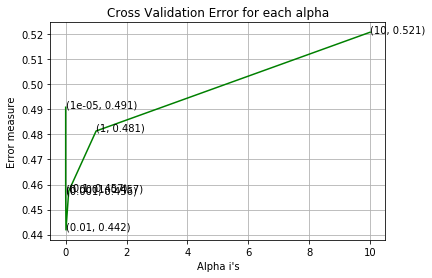

For values of best alpha =  0.01 The train log loss is: 0.4414421691079594
For values of best alpha =  0.01 The test log loss is: 0.44187678031754085
Total number of data points : 30001


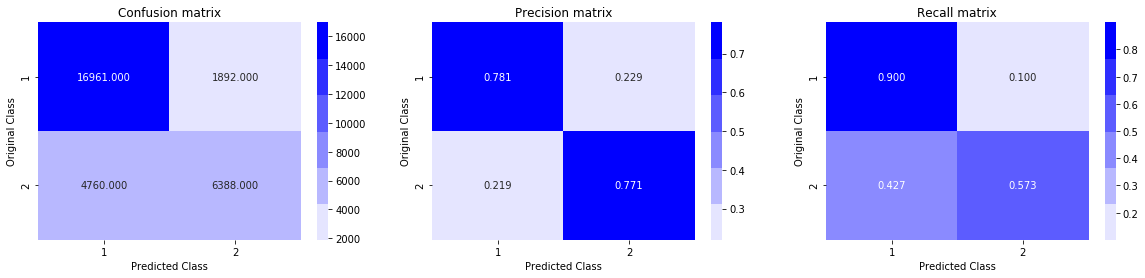

In [32]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Linear SVM with hyperparameter tuning

 14%|███████████▊                                                                       | 1/7 [08:11<49:08, 491.35s/it]

For values of alpha =  1e-05 The log loss is: 0.659795232654984


 29%|███████████████████████▋                                                           | 2/7 [15:31<39:40, 476.05s/it]

For values of alpha =  0.0001 The log loss is: 0.659795232654984


 43%|███████████████████████████████████▌                                               | 3/7 [23:33<31:51, 477.90s/it]

For values of alpha =  0.001 The log loss is: 0.659795232654984


 57%|███████████████████████████████████████████████▍                                   | 4/7 [34:07<26:13, 524.63s/it]

For values of alpha =  0.01 The log loss is: 0.4904246570182551


 71%|███████████████████████████████████████████████████████████▎                       | 5/7 [44:47<18:38, 559.13s/it]

For values of alpha =  0.1 The log loss is: 0.5777363168876372


 86%|███████████████████████████████████████████████████████████████████████▏           | 6/7 [57:00<10:11, 611.46s/it]

For values of alpha =  1 The log loss is: 0.6355067035307416


100%|█████████████████████████████████████████████████████████████████████████████████| 7/7 [1:20:44<00:00, 692.03s/it]


For values of alpha =  10 The log loss is: 0.6570723935113744


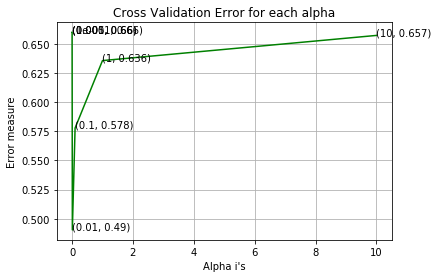

For values of best alpha =  0.01 The train log loss is: 0.4885241890540359
For values of best alpha =  0.01 The test log loss is: 0.4904246570182551
Total number of data points : 30001


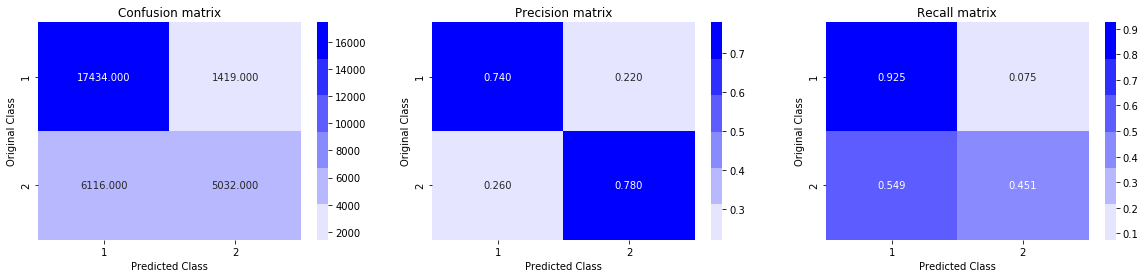

In [33]:
from tqdm import tqdm
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## XGBoost

In [34]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.68472	valid-logloss:0.68466
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61447	valid-logloss:0.61456
[20]	train-logloss:0.56371	valid-logloss:0.56408
[30]	train-logloss:0.52561	valid-logloss:0.52625
[40]	train-logloss:0.49639	valid-logloss:0.49714
[50]	train-logloss:0.47350	valid-logloss:0.47440
[60]	train-logloss:0.45537	valid-logloss:0.45643
[70]	train-logloss:0.44063	valid-logloss:0.44182
[80]	train-logloss:0.42885	valid-logloss:0.43014
[90]	train-logloss:0.41908	valid-logloss:0.42049
[100]	train-logloss:0.41103	valid-logloss:0.41260
[110]	train-logloss:0.40436	valid-logloss:0.40603
[120]	train-logloss:0.39878	valid-logloss:0.40054
[130]	train-logloss:0.39384	valid-logloss:0.39575
[140]	train-logloss:0.38981	valid-logloss:0.39184
[150]	train-logloss:0.38630	valid-logloss:0.38855
[160]	train-logloss:0.38319	valid-logloss:0.38567
[170]	trai